# Use case - estimating parameters for sums of random variables

Modeling plant root growth motivates this example.  We are inspired by a simple 2-D model of root growth in which a root grows in a straight line at a certain angle for a given distance before modifying the angle and repeating the process.  We are interested in the distribution of root growth by depth.  It turns out that if we model the changes in slope directly, as opposed to the angle, we can reduce the formula of the depth of the root at a distance $r$ from where it emanated to
$$
y = v' x
$$
where $x_i, i = 1, \ldots, k$ is the change in slope, $k-1$ is the number of kinks in the root prior to reaching radius $r$, $x_0 = 0$, and $v$ is related to the distance the root travels before changing direction.

We will assume $x_i, i=1, \ldots, k$ are i.i.d, and for the sake of this example, instead of working with real data, we will be simulating data and then trying to recover the true parameters.

All of this work relies on the moment generating function (MGF).  Critically, we can easily go from a univariate MGF of a distribution, $M$, to a MGF for the linear combination of iid random variables from that distribution since
$$
\mathbb{E}[e^{t v'x}] = \prod_{i=1}^{k} \mathbb{E}[e^{t v_i x_i}] = \prod_{i=1}^{k} M(v_i t).
$$

Once we have a moment generating function, we can recover the underlying parameters using the generalized method of moments (see the [README](./README.md)).

## Skew normal distribution

For motivation, we will use the skew normal distribution, which is not stable in the sense that the linear combination does not live within the same family of distributions from which the individual components came.  You can find details about the skew normal distribution [here](https://en.wikipedia.org/wiki/Skew_normal_distribution).  It is possible to write down the density of a sum of iid skew normal random variables, but it is fairly cumbersome [(Nadarajah and Rui, 2017)](https://www.sciencedirect.com/science/article/pii/S0377042716303041).  [Pewsey (2010)](https://www.tandfonline.com/doi/abs/10.1080/02664760050120542) has a good analysis of issues faced when estimating the parameters of a skew normal distribution.

For our purposes here, we only need to know the moment generating function of a skew normal distribution, which is
$$
M(t) = 2 * \exp \Big( \xi t + \frac{\omega^2 t^2}{2} \Big) \; \Phi(\omega \delta t)
$$
where $\Phi$ is the cdf of a standard normal distribution, $\xi$ and $\omega$ are the parameters that shift and scale a base distribution, and 
$$
\delta = \frac{\alpha}{\sqrt{1 + \alpha^2}}.
$$
The mean and variance of this distribution are
$$
\mu = \xi + \sqrt{\frac{2}{\pi}} \omega \delta \; \text{ and } \sigma^2 = \omega^2 \Big( 1 - \frac{2}{\pi} \delta^2 \Big).
$$
The skewness (defined as $\mathbb{E}[(X - \mu)^3/\sigma^3]$) is 
$$
\gamma = \frac{4 - \pi}{2} \Big( \frac{ \frac{2}{\pi} \delta^2 }{1 - \frac{2}{\pi} \delta^2} \Big)^3.
$$

## Outline of notebook

Below, we will begin by checking that all is working out when estimating the parameters for realizations from a skew normal distribution.  Then we will move on to estimating the parameters when working with a linear combination of skew normal distribution.  In both cases we will use both the empirical aympototic variance estimators and functional asymptotic variance estimators (see the [README](./README.md)).  The results will be similar, but we know from [Example 2](./gmmfun-example-02-asymptotics.ipynb) that the functional approach is more efficient.

## Function definitions

To begin we load the necessary packages, set up constants, and define several functions.  It will be helpful to move between various parameterizations of a skew normal distribution.  Functions like `dxo_from_axo` do that, which transforms from the $(\alpha, \xi, \omega)$ parameterization to the $(\delta, \xi, \omega)$ parameterization.  We also define several moment generating related functions (those with `mgf` in their name).  Lastly, we define a utility function for plotting.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 3]

In [2]:
import jax.numpy as jnp
from jax import grad
from jax.tree_util import Partial
from jax.scipy.stats.norm import cdf as Phi
import numpy as np
from scipy.stats import skewnorm, skew
from gmmfun import GmmMgf4, GmmMgf, GmmMgfAvar

In [3]:
TWO_OVER_PI = 2 / np.pi
ROOT_TWO_OVER_PI = np.sqrt(TWO_OVER_PI)

lower_bounds_dxo = jnp.array([-1.0, -jnp.inf, 0.0])
upper_bounds_dxo = jnp.array([ 1.0, jnp.inf, jnp.inf])
bounds_dxo = (lower_bounds_dxo, upper_bounds_dxo)

lower_bounds_ams = jnp.array([-jnp.inf, -jnp.inf, 0.0])
upper_bounds_ams = jnp.array([ jnp.inf, jnp.inf, jnp.inf])
bounds_ams = (lower_bounds_ams, upper_bounds_ams)

In [4]:
def alpha_from_delta(delta):
    return delta / jnp.sqrt(1 - delta**2)

def delta_from_alpha(alpha):
    return alpha / jnp.sqrt(1 + alpha**2)

def dxo_from_axo(axo):
    delta = axo[0] / jnp.sqrt(1 + axo[0]**2)
    return jnp.array([delta, axo[1], axo[2]])

def axo_from_dxo(dxo):
    alpha = dxo[0] / jnp.sqrt(1 - dxo[0]**2)
    return jnp.array([alpha, dxo[1], dxo[2]])

def dxo_from_ams(ams):
    delta = ams[0] / jnp.sqrt(1 + ams[0]**2)
    omega = ams[2] / jnp.sqrt(1 - TWO_OVER_PI * delta**2)
    xi = ams[1] - ROOT_TWO_OVER_PI * omega * delta
    return jnp.array([delta, xi, omega])

def ams_from_dxo(dxo):
    alpha = dxo[0] / jnp.sqrt(1 - dxo[0]**2)
    mu = dxo[1] + ROOT_TWO_OVER_PI * dxo[2] * dxo[0]
    sig = dxo[2] * jnp.sqrt(1 - TWO_OVER_PI * dxo[0]**2)
    return jnp.array([alpha, mu, sig])

def gamma_from_delta(delta):
    z = TWO_OVER_PI * delta**2
    return 0.5 * (4 - np.pi) * (z / (1 - z))**3

def delta_from_gamma(gamma):
    z_odds = jnp.power(2 * gamma / (4 - jnp.pi), 1/3)
    z = z_odds / (1 + z_odds)
    return jnp.sign(z) * jnp.sqrt(z / TWO_OVER_PI)

def skew_norm_sample_moments(x):
    """Sample moments of alpha, mu, sigma, gamma, delta"""
    mu_hat = np.mean(x)
    sig_hat = np.std(x)
    skew_hat = skew(x)
    delta_hat = delta_from_gamma(skew_hat)
    alpha_hat = alpha_from_delta(delta_hat)
    return jnp.array([alpha_hat, mu_hat, sig_hat, skew_hat, delta_hat])

def mgf_skew_norm_dxo(t, dxo):
    """MGF of skewnormal under (delta, xi, omega) parameterization"""
    return 2.0 * jnp.exp(t * dxo[1] + 0.5 * jnp.square(dxo[2] * t)) * Phi(dxo[2] * dxo[0] * t)

def mgf_skew_norm_ams(t, ams):
    """MGF of skewnormal under (delta, xi, omega) parameterization"""
    dxo = dxo_from_ams(ams)
    return mgf_skew_norm_dxo(t, dxo)

def mgf_skew_norm_dxo_dot(v, t, dxo):
    """MGF of a linear combination v'x where x ~ SkewNormal(delta, xi, omega)"""
    return jnp.prod(jnp.array([mgf_skew_norm_dxo(v_i * t, dxo) for v_i in v]))

def plot_against_skew_norm(x, axo, ngrid=100):
    """Plot sample x against SkewNormal(alpha, xi, omega) density, which is Scipy parameterization"""
    fig, ax = plt.subplots(1, 1)
    sknorm = skewnorm(axo[0], loc=axo[1], scale=axo[2])
    grid = np.linspace(sknorm.ppf(0.01), sknorm.ppf(0.99), ngrid)
    ax.plot(grid, sknorm.pdf(grid), 'k-', lw=2, label='frozen pdf')
    ax.hist(x, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
    return fig, ax

## True parameters

For this example, the following parameters will be used for data generation.

In [5]:
alpha0, mu0, sig0 = 4.0, 1.0, 1.0
ams0 = jnp.array([alpha0, mu0, sig0])
dxo0 = dxo_from_ams(ams0)
axo0 = axo_from_dxo(dxo0)
ams0, dxo0, axo0

(Array([4., 1., 1.], dtype=float32),
 Array([ 0.97014254, -0.22263384,  1.5795041 ], dtype=float32),
 Array([ 4.0000024 , -0.22263384,  1.5795041 ], dtype=float32))

In [6]:
# ams_from_dxo(dxo_from_ams(ams0))

In [7]:
# dxo_from_axo(axo_from_dxo(dxo0))

## Estimating population parameters for a single variable

In this section, we will estimate the parameters for observations from a single variable.  We define the sample size `N`, sample `N` observations from a SkewNormal($\alpha, \xi, \omega$) distribution, and then plot the results against the corresponding density.

In [8]:
N = 200
np.random.seed(12346)
x = skewnorm.rvs(axo0[0], loc=axo0[1], scale=axo0[2], size=N)

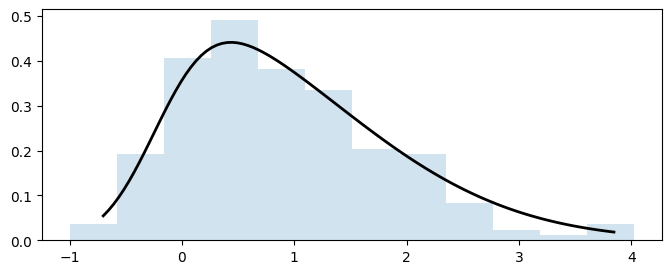

In [9]:
fig, ax = plot_against_skew_norm(x, axo0)

### Initialize using 3 moments

It is important when using the optimization routines present in `GmmMgf` and similar classes to initialize the optimization at a reasonable value.  Otherwise, it is possible to get stuck in a local mode, which creates misleading results.  Having tried various initialization routines, it does seem important to initialize the skew in the correct direction.  Initializing at zero can result in an estimate with little skew, i.e. at a normal approximation.  When this occurs, the p-value suggests reject and the j statistic is quite large.

In [10]:
# alpha, mu, sig, gamma (skewness), and delta
samp_moments = skew_norm_sample_moments(x)
samp_moments

Array([2.3676276 , 0.8997479 , 0.9108185 , 0.69639456, 0.92120284],      dtype=float32)

In [11]:
ams_init_3 = jnp.array([jnp.sign(skew(x)), 0.0, 1.0])
dxo_init_3 = dxo_from_ams(ams_init_3)

In [12]:
mgf_3 = GmmMgf(mgf_skew_norm_dxo, bounds_dxo, 3, x)
out_init = mgf_3.opt_I(dxo_init_3)
dxo_init = out_init.params

You can see from `dxo_init` that we have recovered values that are reasonable given the true values.

In [13]:
dxo_init

Array([ 0.95447195, -0.17052783,  1.4053757 ], dtype=float32)

Lastly, the J statistic below is zero, telling us that we have indeed solved a system of 3 equation and 3 unknowns exactly.

In [14]:
mgf_3.jstat

Array(3.7658765e-11, dtype=float32, weak_type=True)

### Using 4 moments and empirical variance

Next, we will estimate the parameters and test if the data seems to come from a skew normal distribution using 4 moments.  The results are similar, but now we also have a p-value to check to test whether the data comes from a skew normal distribution or not.

In [15]:
mgf_4 = GmmMgf4(mgf_skew_norm_dxo, bounds_dxo, x)
out = mgf_4.opt_I(dxo_init)
out.params

Array([ 0.95269465, -0.15897699,  1.3979135 ], dtype=float32)

In [16]:
trace_mgf_4 = mgf_4.update_both(5, verbose=True)
[out.params for out in trace_mgf_4]

[2023-06-20 12:00:06.586763]: Iteration 1
[2023-06-20 12:00:11.122521]: Iteration 2
[2023-06-20 12:00:12.852707]: Iteration 3
[2023-06-20 12:00:14.638484]: Iteration 4
[2023-06-20 12:00:16.508713]: Iteration 5


[Array([ 0.9585216 , -0.18251371,  1.4115748 ], dtype=float32),
 Array([ 0.9585216 , -0.18251371,  1.4115748 ], dtype=float32),
 Array([ 0.9585216 , -0.18251371,  1.4115748 ], dtype=float32),
 Array([ 0.9585216 , -0.18251371,  1.4115748 ], dtype=float32),
 Array([ 0.9585216 , -0.18251371,  1.4115748 ], dtype=float32)]

As seen by the p-value, we will not reject that this data came from a skew normal distribution.

In [17]:
mgf_4.pval, mgf_4.jstat

(0.8369697225145359, Array(0.04234174, dtype=float32, weak_type=True))

### Using the functional aysmptotic variance approach

We can repeat this using the functional asympototic variance approach.  This takes longer to run, but is more efficient (see [Example Notebook 2](./gmmfun-example-02-asymptotics)).

In [18]:
mgf_4_avar = GmmMgfAvar(mgf_skew_norm_dxo, bounds_dxo, 4, x)
out = mgf_4_avar.opt_I(dxo_init)
out.params

Array([ 0.95268834, -0.15896747,  1.3979083 ], dtype=float32)

In [19]:
# This will take a while
trace_mgf_4_avar = mgf_4_avar.update_both(5, verbose=True)

[2023-06-20 12:00:21.686213]: Iteration 1
[2023-06-20 12:01:17.763122]: Iteration 2
[2023-06-20 12:02:08.486191]: Iteration 3
[2023-06-20 12:02:52.637637]: Iteration 4
[2023-06-20 12:03:36.414695]: Iteration 5


In [20]:
[out.params for out in trace_mgf_4_avar]

[Array([ 0.95750415, -0.17996445,  1.4123945 ], dtype=float32),
 Array([ 0.95750415, -0.17996445,  1.4123945 ], dtype=float32),
 Array([ 0.95750415, -0.17996445,  1.4123945 ], dtype=float32),
 Array([ 0.95750415, -0.17996445,  1.4123945 ], dtype=float32),
 Array([ 0.95750415, -0.17996445,  1.4123945 ], dtype=float32)]

In [21]:
mgf_4_avar.pval, mgf_4_avar.jstat

(0.9137880271986785, Array(0.01172062, dtype=float32, weak_type=True))

## Estimating population parameters for linear combinations of iid random variables

Now, instead of estimating the parameters from observations from a single random variable, let us estimate the parameters from the linear combination of several random variables.  First, we remind ourselves of the true values we are estimating.  Then, we set the sample size to `N_lc`, define $v$, which is used to compute the linear combination $y = v'x$, and then generate samples of $y$ when the components of $x$ are iid as $\text{SkewNormal}(\delta_0, \xi_0, \omega_0)$.  We plot the histogram of the subsequent samples.  Lastly, we define the moment generating function for this choice of $v$.

In [22]:
dxo0

Array([ 0.97014254, -0.22263384,  1.5795041 ], dtype=float32)

In [23]:
N_lc = 200
M = 2
v = np.array([1.0, 2.0, 3.0])[0:M]

np.random.seed(12346)
X = skewnorm.rvs(axo0[0], loc=axo0[1], scale=axo0[2], size=(N_lc, M))
y = np.matmul(X, v)

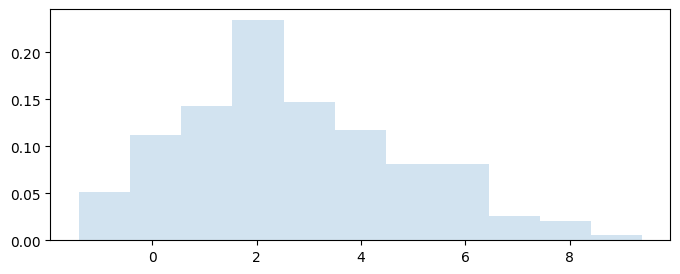

In [24]:
plt.hist(y, density=True, bins='auto', histtype='stepfilled', alpha=0.2);

In [25]:
mgf_skew_norm_lc_dxo = Partial(mgf_skew_norm_dxo_dot, v)

### Initialization

Like above, we will use GMM with 3 moments to create the initial value when optimizing with more moments.

In [26]:
ams_init_3_lc = jnp.array([jnp.sign(skew(y)), 0.0, 1.0])
dxo_init_3_lc = dxo_from_ams(ams_init_3_lc)

In [27]:
mgf_3_lc = GmmMgf(mgf_skew_norm_lc_dxo, bounds_dxo, 3, y)
out_init_lc = mgf_3_lc.opt_I(dxo_init_3_lc)
dxo_init_lc = out_init_lc.params
dxo_init_lc

Array([ 0.9356721 , -0.15728925,  1.422096  ], dtype=float32)

### Empirical variance

Here we estimate the parameters using 4 moments and the empirical estimator for the asympototic variance.  We recover parameters that are similar to the underlying true values and we do not reject the data coming from a skew normal distribution.

In [28]:
mgf_4_lc = GmmMgf(mgf_skew_norm_lc_dxo, bounds_dxo, 4, y)
out = mgf_4_lc.opt_I(dxo_init_lc)
out.params

Array([ 0.9238279 , -0.05517761,  1.3466107 ], dtype=float32)

In [29]:
trace_mgf_4_lc = mgf_4_lc.update_both(5, verbose=True)
[out.params for out in trace_mgf_4_lc]

[2023-06-20 12:04:33.053573]: Iteration 1
[2023-06-20 12:04:41.691948]: Iteration 2
[2023-06-20 12:04:47.806821]: Iteration 3
[2023-06-20 12:04:53.057577]: Iteration 4
[2023-06-20 12:04:58.310297]: Iteration 5


[Array([ 0.973757  , -0.25242603,  1.4390903 ], dtype=float32),
 Array([ 0.97445726, -0.25563857,  1.4406226 ], dtype=float32),
 Array([ 0.97445726, -0.25563857,  1.4406226 ], dtype=float32),
 Array([ 0.97445726, -0.25563857,  1.4406226 ], dtype=float32),
 Array([ 0.97445726, -0.25563857,  1.4406226 ], dtype=float32)]

In [30]:
mgf_4.pval, mgf_4.jstat

(0.8369697225145359, Array(0.04234174, dtype=float32, weak_type=True))

### Using functional aymptotic variance

Now we repeat the process, but this time using 4 moments and the functinal estimator of the asmpytotic variance.  The results are similar.

In [31]:
# This will take a while
mgf_4_avar_lc = GmmMgfAvar(mgf_skew_norm_lc_dxo, bounds_dxo, 4, y)
out = mgf_4_avar_lc.opt_I(dxo_init_lc)
out.params

Array([ 0.9238279 , -0.05517761,  1.3466107 ], dtype=float32)

In [32]:
trace_mgf_4_avar_lc = mgf_4_avar_lc.update_both(5, verbose=True)

[2023-06-20 12:05:12.616122]: Iteration 1
[2023-06-20 12:06:33.343073]: Iteration 2
[2023-06-20 12:08:02.420192]: Iteration 3
[2023-06-20 12:09:30.492904]: Iteration 4
[2023-06-20 12:10:47.646789]: Iteration 5


In [33]:
[out.params for out in trace_mgf_4_avar_lc]

[Array([ 0.96807265, -0.2524568 ,  1.482571  ], dtype=float32),
 Array([ 0.9688875 , -0.25712025,  1.4981046 ], dtype=float32),
 Array([ 0.96858984, -0.2566607 ,  1.4990695 ], dtype=float32),
 Array([ 0.96857697, -0.25666562,  1.4990743 ], dtype=float32),
 Array([ 0.96857697, -0.25666562,  1.4990743 ], dtype=float32)]

In [34]:
mgf_4_avar_lc.pval, mgf_4_avar_lc.jstat

(0.3417613101026823, Array(0.9038132, dtype=float32, weak_type=True))

### Compared to Gaussian

Finally, let's test the data against the null hypothesis that it comes from a Gaussian distribution.  You can see below from the p-value that we reject that hypothesis.

In [35]:
def mgf_norm(t, theta):
    return jnp.exp(t * theta[0] + 0.5 * jnp.square(theta[1] * t))

lower_bounds = jnp.array([-jnp.inf, 0.0])
upper_bounds = jnp.array([ jnp.inf, jnp.inf])
bounds_norm = (lower_bounds, upper_bounds)

In [36]:
norm_init = jnp.array([jnp.mean(y), jnp.std(y)])

In [37]:
mgf_4_norm_lc = GmmMgf(mgf_norm, bounds_norm, 4, y)
out = mgf_4_norm_lc.opt_I(norm_init)
out.params

Array([2.6603673, 2.2968976], dtype=float32)

In [38]:
trace_mgf_4_norm_lc = mgf_4_norm_lc.update_both(5, verbose=True)
[out.params for out in trace_mgf_4_norm_lc]

[2023-06-20 12:12:05.991760]: Iteration 1
[2023-06-20 12:12:07.808416]: Iteration 2
[2023-06-20 12:12:08.133064]: Iteration 3
[2023-06-20 12:12:08.461940]: Iteration 4
[2023-06-20 12:12:08.744547]: Iteration 5


[Array([2.7241116, 1.8758808], dtype=float32),
 Array([2.6623006, 1.7858589], dtype=float32),
 Array([2.635492 , 1.7693557], dtype=float32),
 Array([2.6269078, 1.7651445], dtype=float32),
 Array([2.624493 , 1.7641039], dtype=float32)]

In [39]:
mgf_4_norm_lc.pval, mgf_4_norm_lc.jstat

(7.519335707861785e-06, Array(23.596066, dtype=float32, weak_type=True))

# Conclusion

Herein, we showed how to using the `gmmfun` package to estimate the parameters of a distribution that is only observed via a linear combination of several iid random variates from that distribution.

When working in the Bayesian setting, either one would need to marginalize out these latent variables to arrive at a closed form likelihood of the observed, or one would need to generate posterior samples from those latent variables themselves in order to generate estimates of the parameters.  The latter, of course, can be lead to Markov Chain Monte Carlos samplers with high autocorrelation in the parameter samples.

In contrast, as seen here, given the moment generating function of the underlying distribution, one can use the generalized method of moments in this scenario to estimate the undrlying parameters of interest fairly rapidly.  Further, the asymptotic variance can be easily computed exactly, not estimated, which leads to a more efficient estimator at a cost of slightly longer computation times.